# Training a Siamese model with a triplet loss function on MNIST dataset using PyTorch

In this notebook, you can find the example code for this repo (https://github.com/ziadloo/Siamese-model-in-Pytorch) that trains a Siamese model using a triplet loss function over the MNIST dataset. The same technique could be used to train a Siamese model on any dataset. You can also find in-depth explanation on this topic on this [article]().

Let's start by loading the needed libraries.

In [1]:
import torch
from torch import nn
import torchvision
import random
import copy
from torchvision import datasets
import torchvision.transforms as transforms

import sys
import os

# Add the path of the parent directory to sys.path
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

# Now you can perform relative imports
from Siamese import SiameseDataLoader, SiameseDataset, SiameseModel, triplet_loss # SiameseSampleGenerator

torch.manual_seed(42)
random.seed(42)

/home/mehran/.conda/envs/whisper/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/mehran/.conda/envs/whisper/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Loading the dataset

First, we need to load the MNIST dataset. PyTorch has helper method to make it easy.

In [2]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.912], std=[0.168]),
])

training_mnist = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

test_mnist = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

A Siamese model consumes the data in a very specific way. Each mini-batch should be composed of two tensors. Both of these tensors should be the same shape as of your dataset. For example, in the case of MNIST, each sample is an image of 28*28 pixels. Here, as part of the augmentation we will be upscaling them to 32*32. So each input sample is a 1*32*32 tensor. The first 1 is because the images are grayscale.

In our case, if want to have batches of size `b`, each batch will be: `(b*1*32*32, b*1*32*32)`. Meaning each training input will be tuple of two tensors. Each tensor will be of shape `b*1*32*32`. But there's more, the samples in each batch will of the same class as of other batch while no other sample in the batch should of that class. This is depicted in the following image:

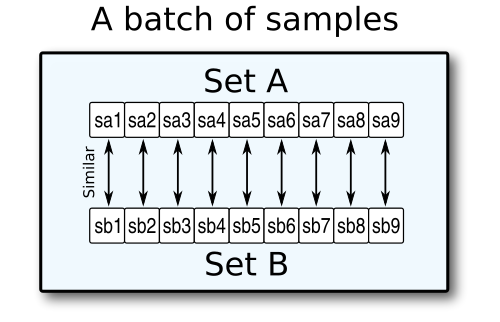

The formal mathematical way of saying the same thing is:

\begin{equation}
  \forall i, j \in B, \begin{cases}
    \text{class(sa[i]) $=$ class(sb[j])}, \:\: & \text{if $i = j$}\\
    \text{class(sa[i]) $\neq$ class(sb[j])}, \:\: & \text{if $i \neq j$} &
  \end{cases}
\end{equation}

The direct result of the above assumption is that the `batch_size` cannot be larger than the number of classes that we have. So here, `batch_size` could be as large as 10. But of course, if we go with 10 our training time will be unacceptably too long. To address this problem we can introduce a second batch dimension and have that as large as our hardware supports (or as large as we like). To distinguish between the two batch sizes, let's call the first one `class_size` and call the second one `batch_size`.

For the problem at hand, having samples (images) of shape `(1, 32, 32)`, a forced class size of 10, and a batch size of 32 (an arbitrary choice), we'll end up with samples of shape `(32, 10, 1, 32, 32)`. This sample shape demands a special treatment which I'll get to later in this notebook. But for now, let's construct our dataloaders.

First, we will group sampels of similar label with each other. And then, we'll create `SiameseDataset` objects based on them. And finally, `SiameseDataLoader` off those.

In [3]:
batch_size = 10
class_count = 10
latent_size = 8

train_samples = [[] for i in range(10)]
for X, y in training_mnist:
    train_samples[y].append(X)

test_samples = [[] for i in range(10)]
for X, y in test_mnist:
    test_samples[y].append(X)

In [4]:
training_generators = [
    torch.utils.data.TensorDataset(torch.stack(train_samples[i]))
    for i in range(class_count)
]
training_data = SiameseDataset(training_generators)
train_dataloader = SiameseDataLoader(
    training_data, batch_size=batch_size, class_count=class_count, shuffle=True
)

# Test dataloader
test_generators = [
    torch.utils.data.TensorDataset(torch.stack(test_samples[i]))
    for i in range(class_count)
]
test_data = SiameseDataset(test_generators)
test_dataloader = SiameseDataLoader(
    test_data, batch_size=batch_size, class_count=class_count
)

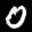

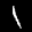

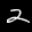

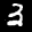

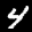

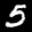

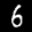

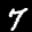

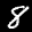

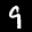

In [5]:
inputs = next(iter(train_dataloader))[0]
for i in range(10):
    tensor = inputs[0, i]
    min_val = tensor.min()
    max_val = tensor.max()
    tensor = (tensor - min_val) / (max_val - min_val)
    img = transforms.functional.to_pil_image(tensor)
    display(img)

## Tower design

The model design of a Siamese tower is nothing in particular. Any model that accepts input format and generates tensors of the desired dimensionality, will do. It's a good reminder here to say that the dimensionality of the output tensors in a Siamese model is rather arbitray. But it's usually each sample results in a one dimensional tensor. The size of that dimension should be selected based on the difficulty of the problem. It's an important knowledge to have that if you select a too large of a dimension for your model's output, it will most likely result in mode collapse. So, it's adviced that to select as small dimension as you can get away with, rather than a larger number. 

In [6]:
class MnistCnn(nn.Module):
    def __init__(self, latent_size):
        super(MnistCnn, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.linear = nn.Sequential(
            nn.Linear(32 * 8 * 8, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
        )
        self.fc = nn.Linear(32, latent_size)

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        x = self.fc(x)
        return x

Next, we'll instantiate an object from the tower and wrap it in a Siamese model.

In [7]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [8]:
# Tower model
tower = MnistCnn(latent_size)
# Siamese model
siamese = SiameseModel(tower).to(device)
print(siamese)

SiameseModel(
  (tower): MnistCnn(
    (cnn): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (linear): Sequential(
      (0): Linear(in_features=2048, out_features=32, bias=True)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=32, out_features=32, bias=True)
      (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (fc): Linear(in_features=32, out_features=8, bias=True)
  )
)


## Training the model

The training step of a Siamese model is exactly the same as any ordinary model. The only difference is that the dataloader as well as the model deal with the data in pairs.

In [9]:
def accuracy(v1, v2):
    scores = torch.matmul(v1, v2.permute(*range(v2.dim() - 2), -1, -2))
    # scores = torch.mm(v1, v2.t())
    m = torch.argmax(scores, dim=-1).to(v1.device)
    i = torch.arange(scores.shape[-1]).to(v1.device)

    if scores.dim() - i.dim() > 1:
        i = i.expand([*scores.shape[:-2], -1])

    marks = torch.where(i == m, torch.tensor(1).to(v1.device), torch.tensor(0).to(v1.device))
    return torch.sum(marks)

def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0
    total_acc = 0
    total_counter = 0
    # The only difference is that the dataloader will return a tuple (s1, s2)
    for batch, (s1, s2) in enumerate(dataloader):
        s1, s2 = s1.to(device), s2.to(device)

        batch_size = s1.shape[0]
        class_size = s1.shape[1]
        
        s1 = s1.view(-1, s1.shape[-3], s1.shape[-2], s1.shape[-1])
        s2 = s2.view(-1, s1.shape[-3], s2.shape[-2], s2.shape[-1])
        
        v1, v2 = model((s1, s2))

        v1 = torch.nn.functional.normalize(v1, dim=-1)
        v2 = torch.nn.functional.normalize(v2, dim=-1)

        v1 = v1.view(batch_size, class_size, -1)
        v2 = v2.view(batch_size, class_size, -1)
        
        loss = loss_fn(v1, v2)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        total_acc += accuracy(v1, v2).item()
        total_counter += batch_size * class_size

    total_loss /= total_counter
    total_acc /= total_counter

    return total_loss, total_acc


def test(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    model.eval()
    test_loss = 0
    test_acc = 0
    num_batches = 0
    with torch.no_grad():
        for s1, s2 in dataloader:
            s1, s2 = s1.to(device), s2.to(device)
            
            batch_size = s1.shape[0]
            class_size = s1.shape[1]
            
            s1 = s1.view(-1, s1.shape[-3], s1.shape[-2], s1.shape[-1])
            s2 = s2.view(-1, s1.shape[-3], s2.shape[-2], s2.shape[-1])
            
            v1, v2 = model((s1, s2))

            v1 = torch.nn.functional.normalize(v1, dim=-1)
            v2 = torch.nn.functional.normalize(v2, dim=-1)
            
            v1 = v1.view(batch_size, class_size, -1)
            v2 = v2.view(batch_size, class_size, -1)
            
            test_loss += loss_fn(v1, v2).item()
            test_acc += accuracy(v1, v2).item()
            num_batches += batch_size * class_size
    test_loss /= num_batches
    test_acc /= num_batches

    return test_loss, test_acc

The only thing left is to train the model.

In [10]:
optimizer = torch.optim.SGD(siamese.parameters(), lr=1e-3, momentum=0.7)
siamese = SiameseModel(tower).to(device)

best_acc = 0
epochs = 20
for t in range(epochs):
    print("--------------------------------------------------------------------------------")
    print(f"Epoch {t+1}/{epochs}")
    train_loss, train_acc = train(train_dataloader, siamese, triplet_loss, optimizer, device)
    test_loss, test_acc = test(test_dataloader, siamese, triplet_loss, device)

    print(f"Train Loss: {train_loss:>7f} \t Train Accuracy: {train_acc:>7f} \t Test Avg Loss: {test_loss:>8f} \t Test Avg Acc: {test_acc:>8f}")
    
    if test_acc > best_acc:
        best_acc = test_acc
        best_tower = MnistCnn(latent_size)
        best_tower.load_state_dict(copy.deepcopy(tower.state_dict()))
        
    train_dataloader.dataset.shuffle()
    test_dataloader.dataset.shuffle()

print("--------------------------------------------------------------------------------")
print("Training is done!")

--------------------------------------------------------------------------------
Epoch 1/20
Train Loss: 0.007541 	 Train Accuracy: 0.844531 	 Test Avg Loss: 0.004195 	 Test Avg Acc: 0.956054
--------------------------------------------------------------------------------
Epoch 2/20
Train Loss: 0.003319 	 Train Accuracy: 0.964250 	 Test Avg Loss: 0.002879 	 Test Avg Acc: 0.969507
--------------------------------------------------------------------------------
Epoch 3/20
Train Loss: 0.002380 	 Train Accuracy: 0.976517 	 Test Avg Loss: 0.002346 	 Test Avg Acc: 0.977915
--------------------------------------------------------------------------------
Epoch 4/20
Train Loss: 0.001954 	 Train Accuracy: 0.981811 	 Test Avg Loss: 0.002086 	 Test Avg Acc: 0.979709
--------------------------------------------------------------------------------
Epoch 5/20
Train Loss: 0.001674 	 Train Accuracy: 0.984818 	 Test Avg Loss: 0.001805 	 Test Avg Acc: 0.983072
---------------------------------------------

## Analyzing the results

With the training done, let's see how the model is doing. Even though we do have the accuracy as part of the training process, but there much more we can dig.

First, let's start by repackaging the test samples into something more suitable for our analysis.

In [11]:
# test_tensor = torch.cat([torch.cat([torch.unsqueeze(test_transform(l), 0) for l in s]) for s in test_samples])
test_tensor = torch.cat([torch.stack(s) for s in test_samples])

print(f"test_tensor.shape: {test_tensor.shape}")

test_tensor.shape: torch.Size([10000, 1, 32, 32])


Now we can use our trained model and generate the embeddings for each of the samples. Once we have the embeddings, a simple matrix multiplication will give us the cosine distance between any two samples.

In [12]:
tower.eval()

with torch.no_grad():
    test_tensor.to(device)
    # Use the best trained tower to generate the embeddings
    embeddings = best_tower(test_tensor)
    embeddings = torch.nn.functional.normalize(embeddings, dim=-1)
    print(f"embeddings.shape: {embeddings.shape}")

# Multiplying the embedding with its transposed will give us the
# similarity between each two sample
similarity = torch.mm(embeddings, embeddings.t())
print(f"similarity.shape: {similarity.shape}")

embeddings.shape: torch.Size([10000, 8])
similarity.shape: torch.Size([10000, 10000])


Now let's visualize the similarity matrix. For the sake of better visibility, the Y axis in the following charts are in logarithmic scaled.

Each chart will show the two histograms. For example, in the first chart, the blue histogram is for the similarity between any two `0` samples in the dataset. While the yellow histogram is for the similarity (dissimilarity) between any `0` and any `1`. The green parts are their overlaps. In a perfect world, there should be no green part but we are living in the real world!

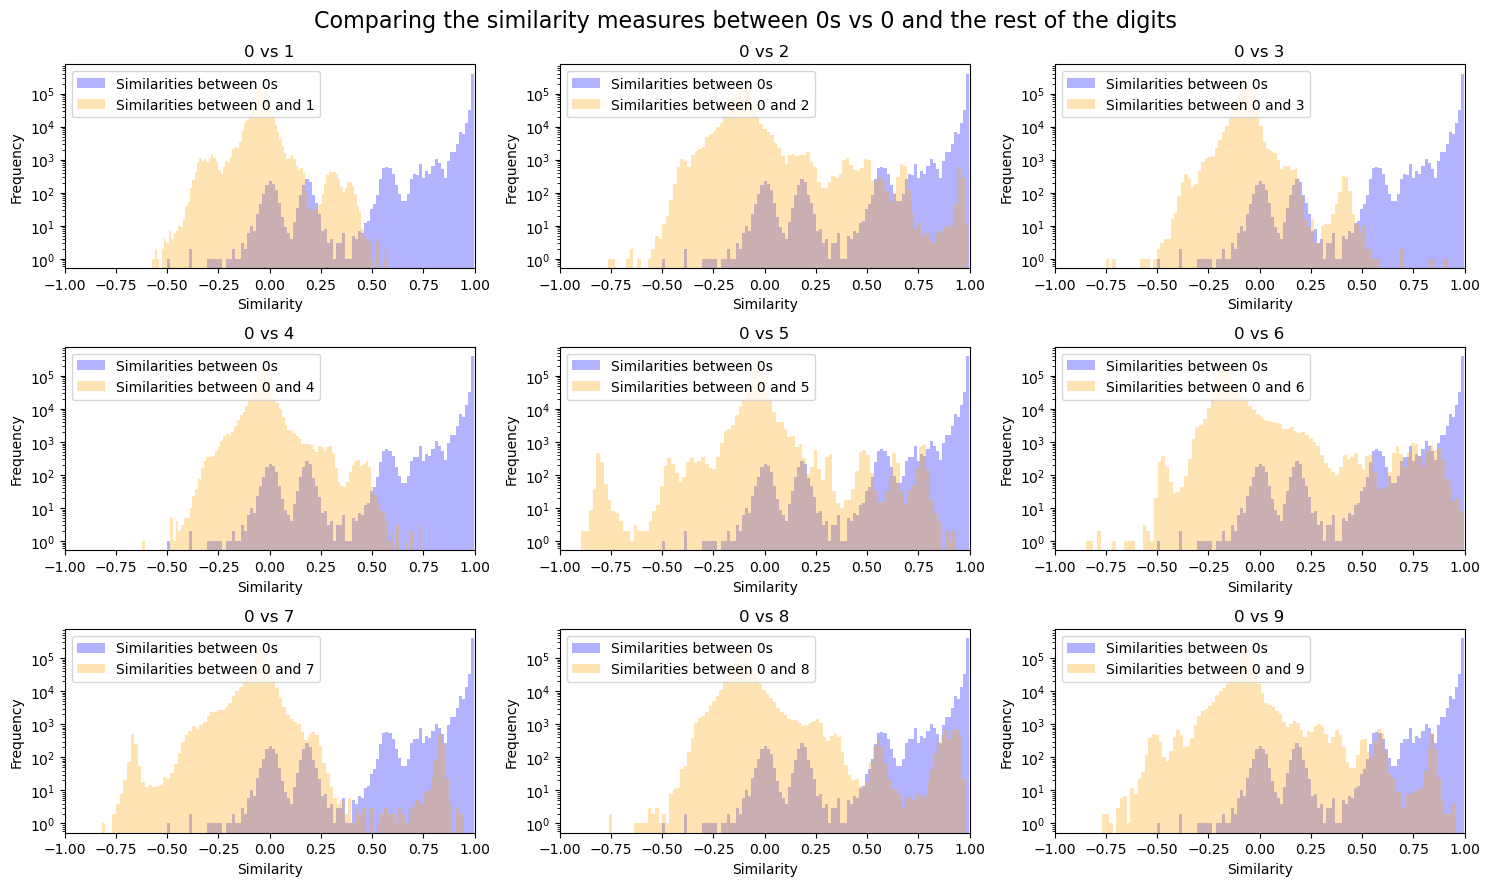

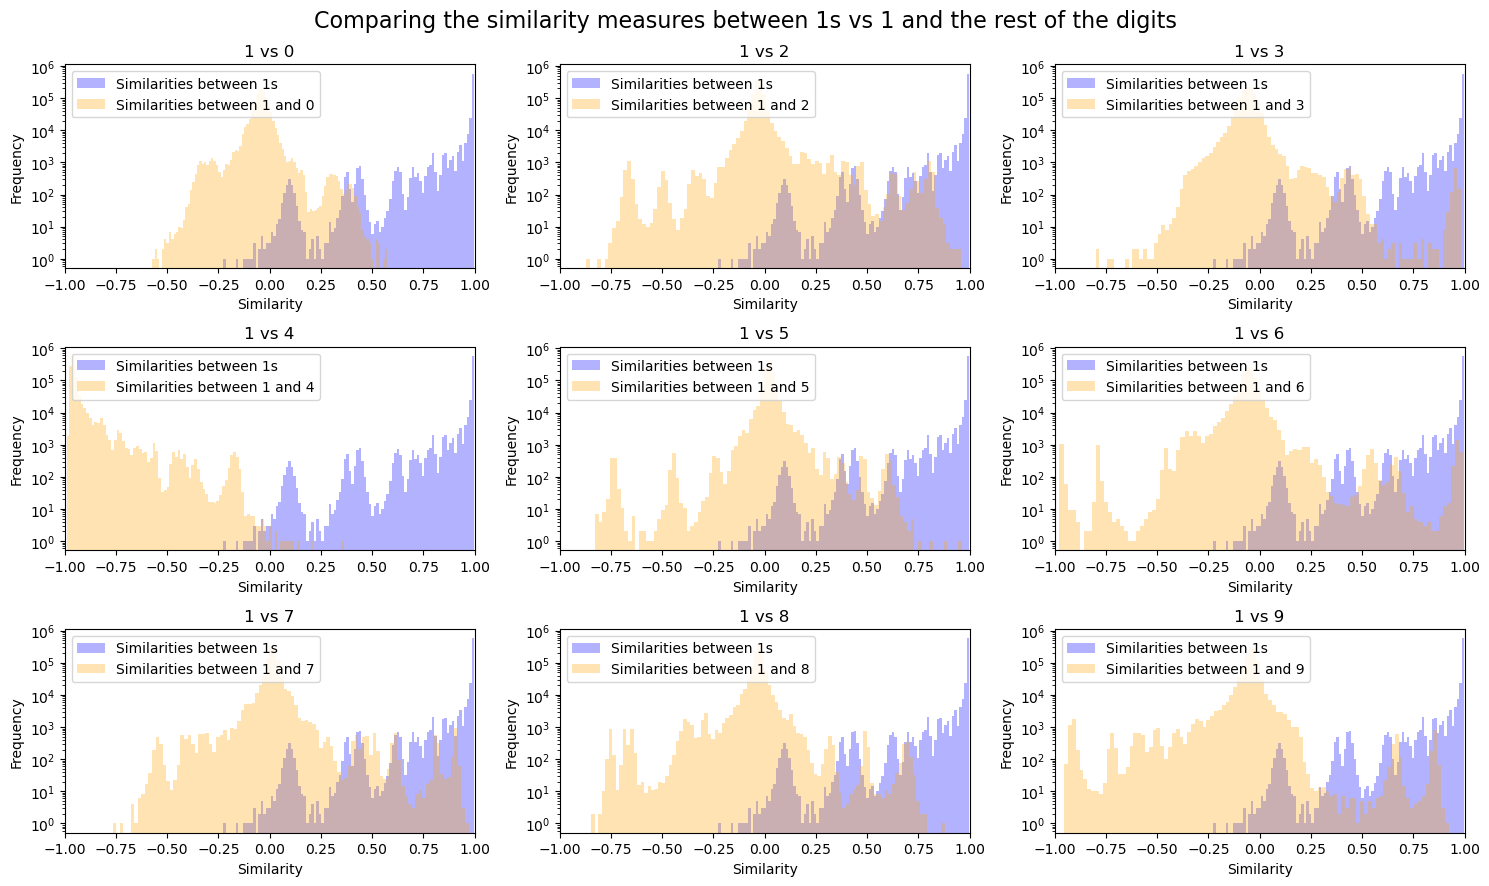

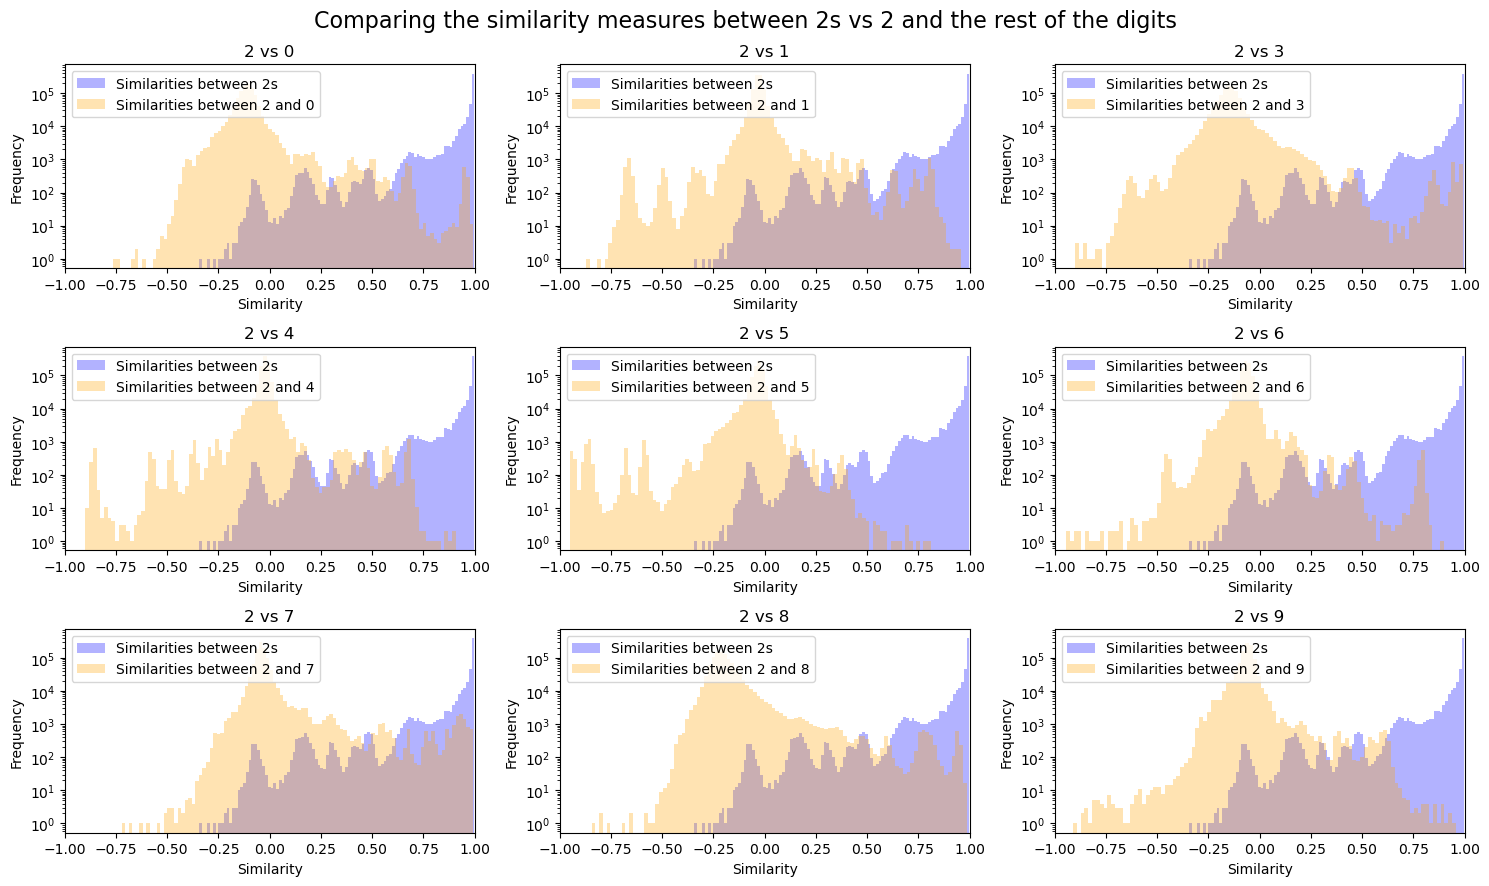

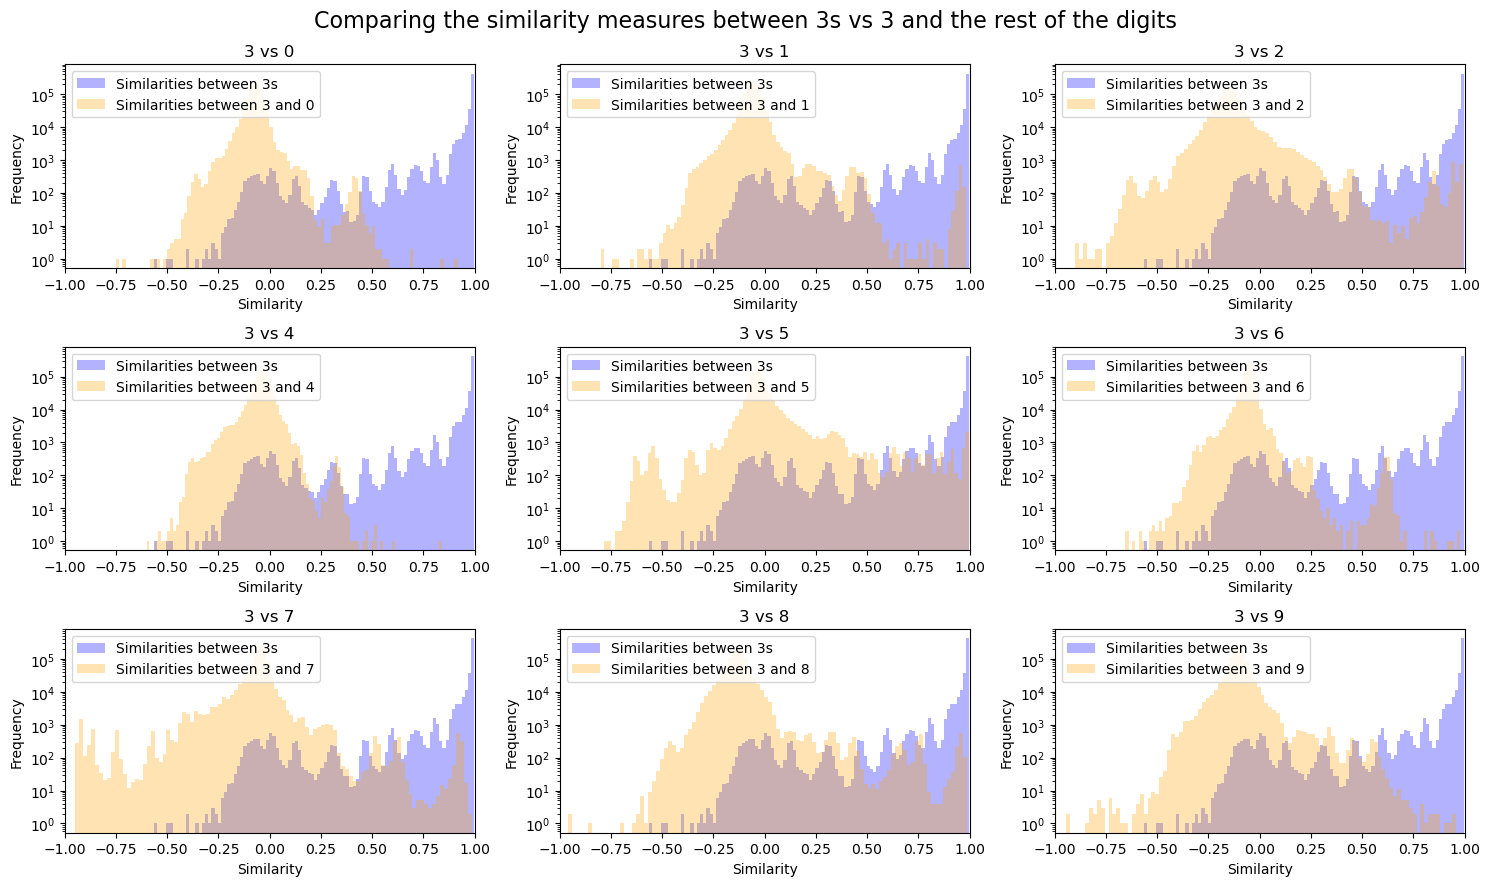

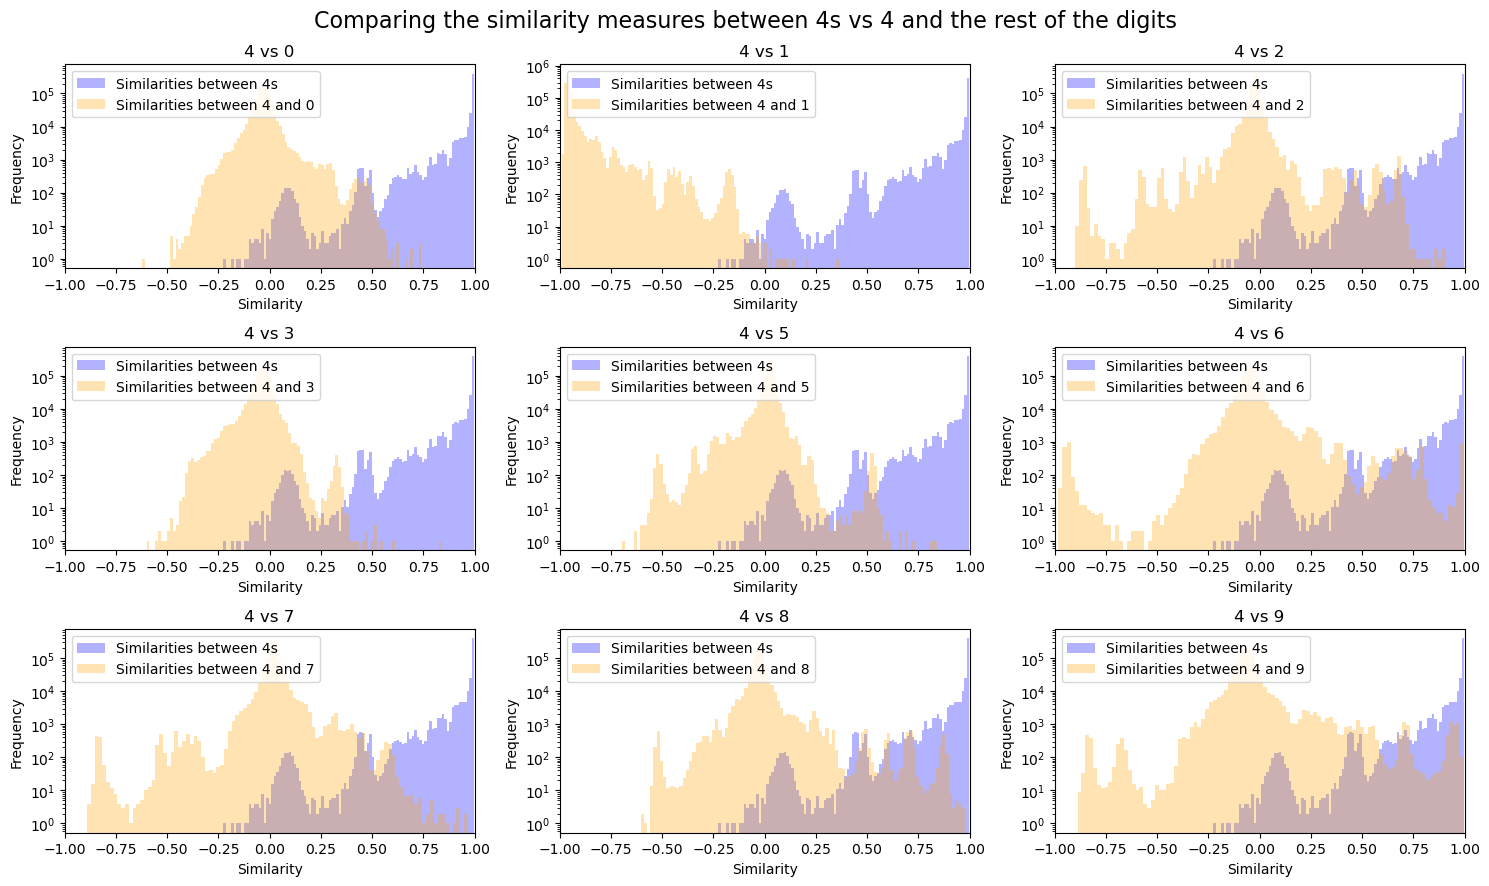

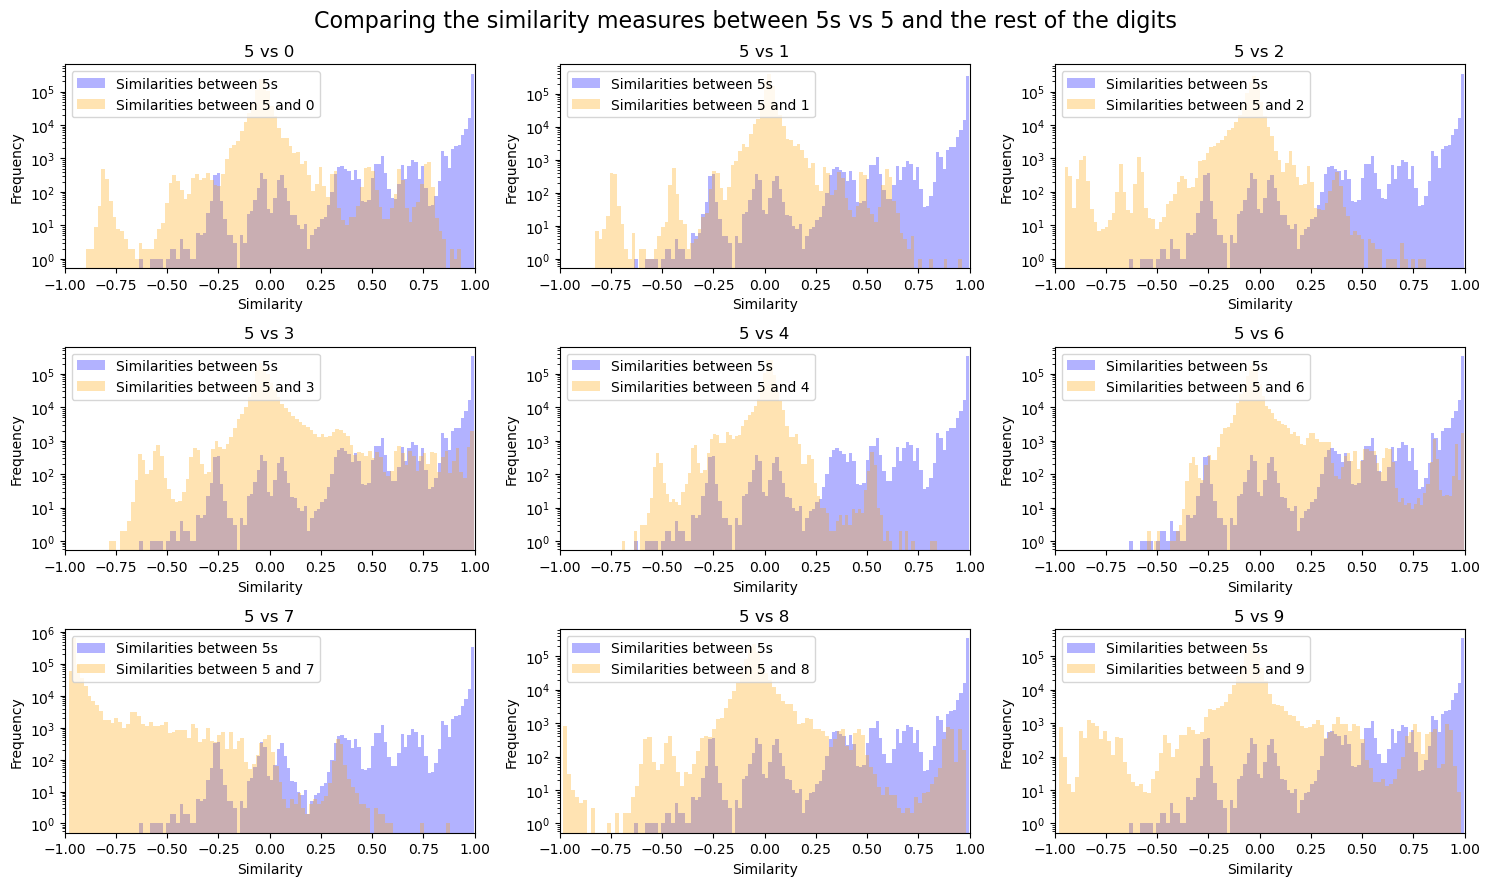

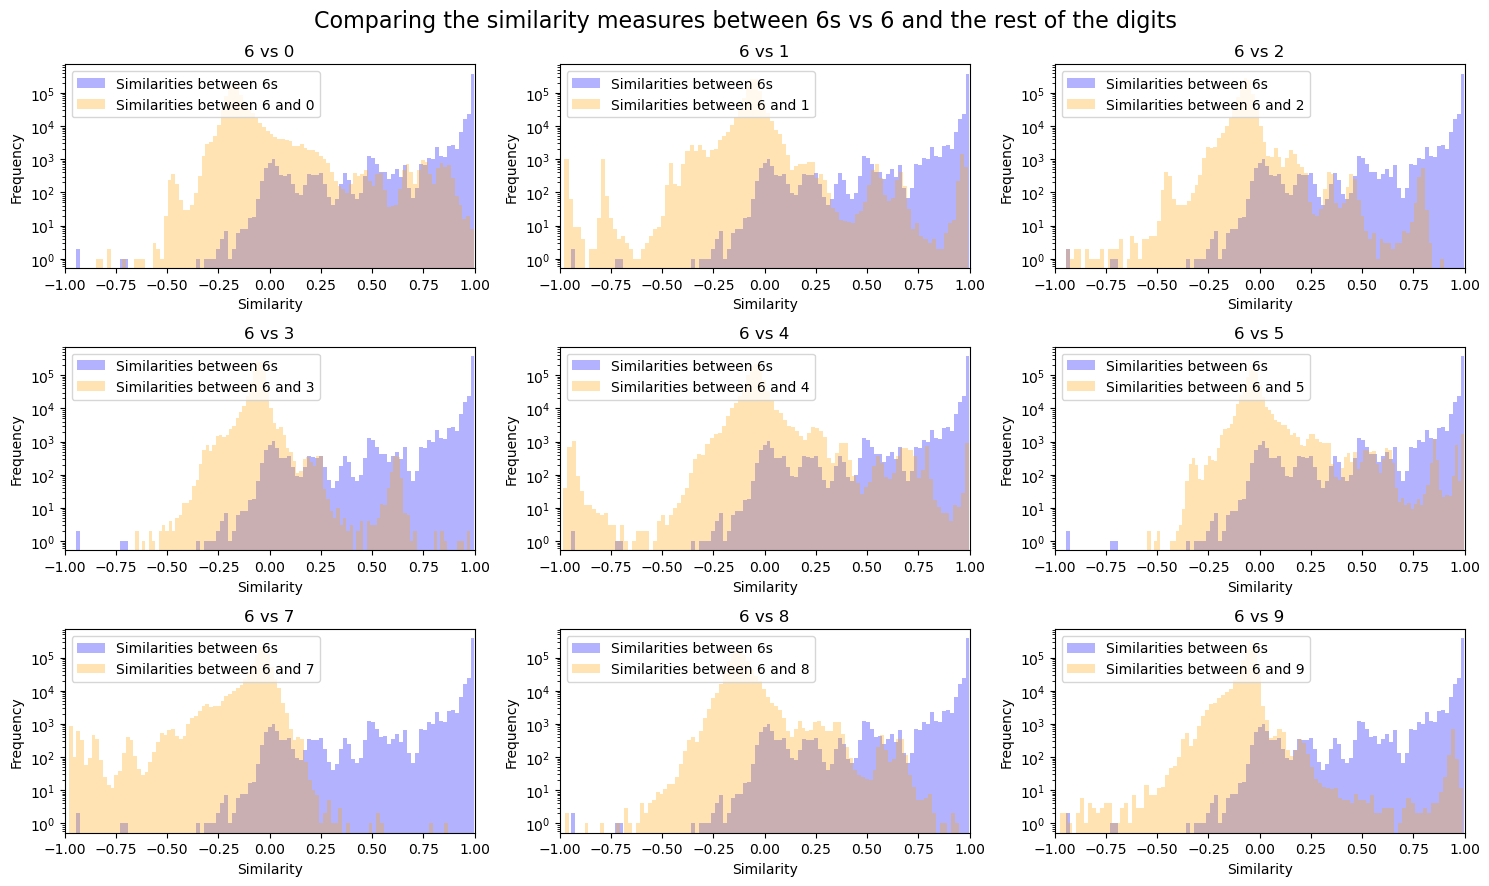

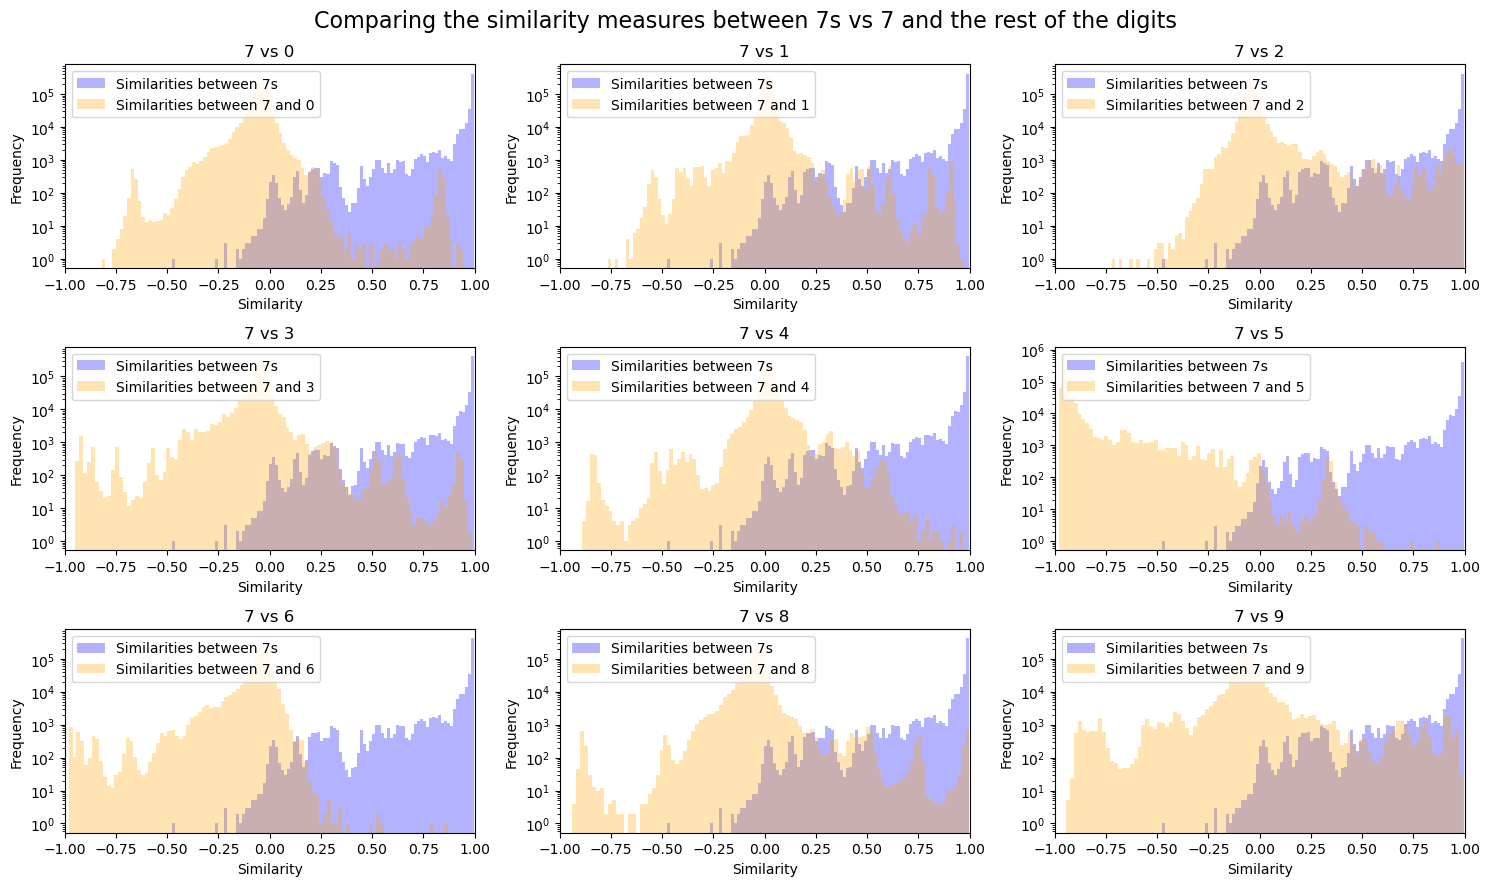

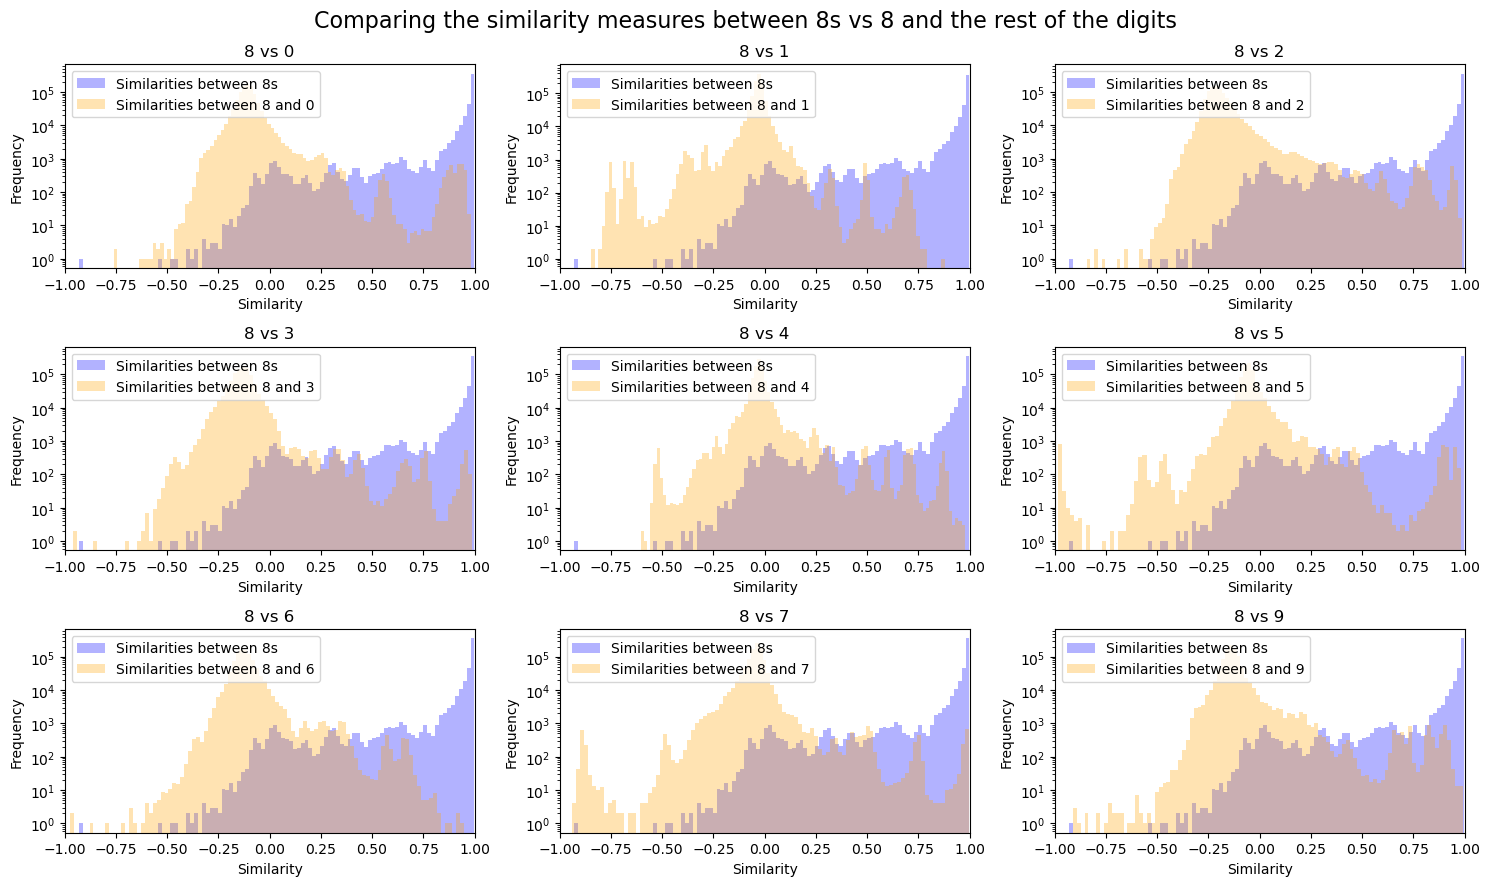

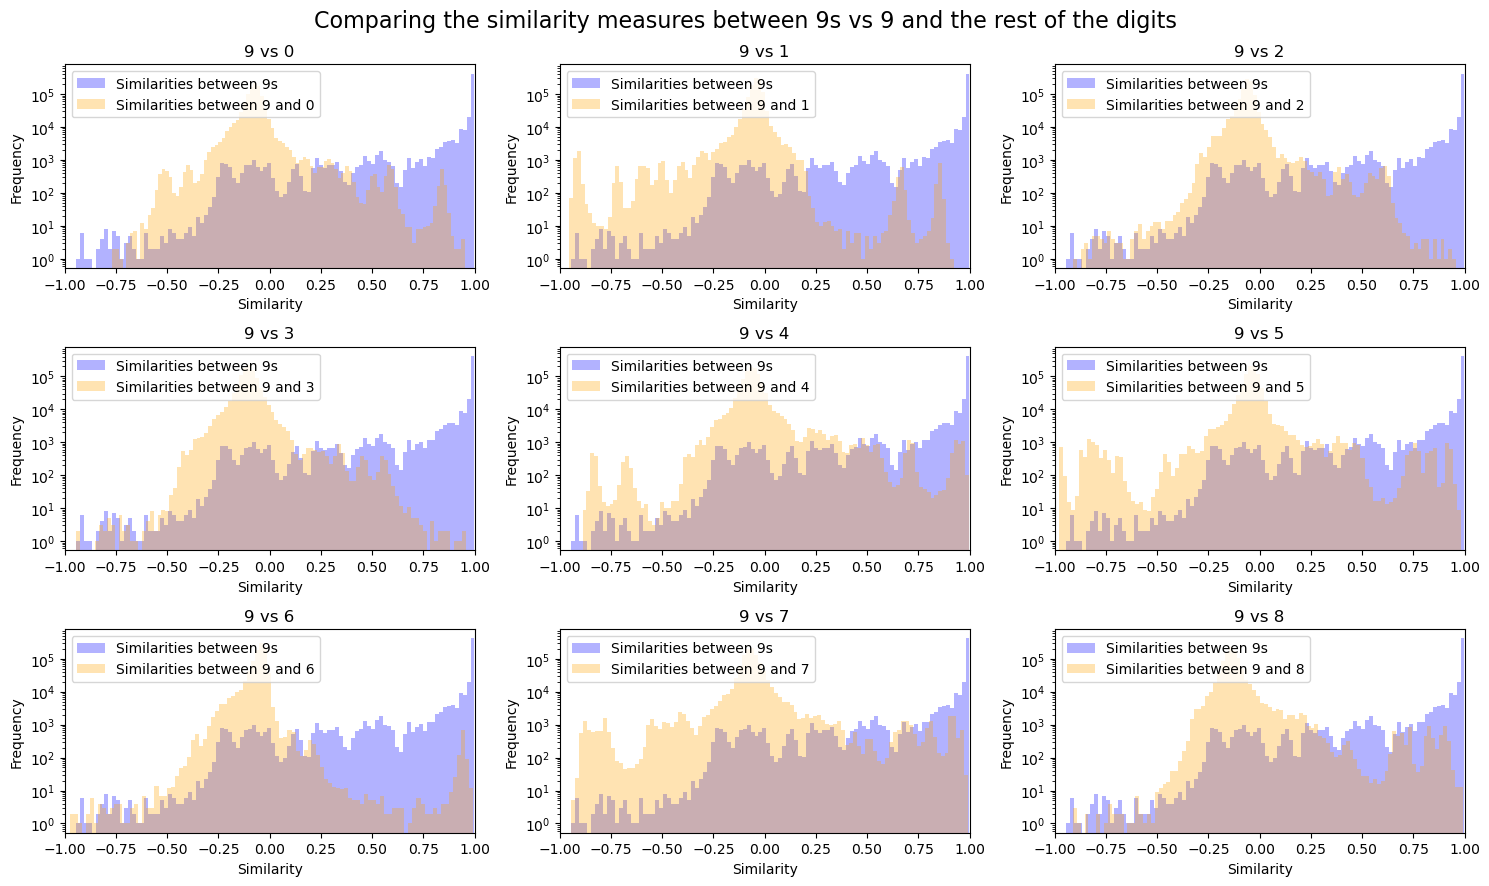

In [13]:
import matplotlib.pyplot as plt


def plot_histograms_in_grid(sim, dis_list, sim_index):
    fig, axes = plt.subplots(3, 3, figsize=(15, 3*3))  # Create a grid of subplots
    
    for i, dis_key in enumerate(dis_list):
        row = i // 3
        col = i % 3
        
        ax = axes[row, col]
        ax.set_xlim(-1, 1)
        
        # Plot histograms for the first pair
        ax.hist(sim, bins=100, alpha=0.3, color='blue', label=f'Similarities between {sim_index}s')
        ax.hist(dis[dis_key], bins=100, alpha=0.3, color='orange', label=f'Similarities between {sim_index} and {dis_key}')
        
        ax.set_title(f'{sim_index} vs {dis_key}')
        ax.set_xlabel('Similarity')
        ax.set_ylabel('Frequency')
        ax.set_yscale('log')
        
        ax.legend(loc='upper left')

    fig.suptitle(f"Comparing the similarity measures between {sim_index}s vs {sim_index} and the rest of the digits", fontsize=16)
    plt.tight_layout()
    plt.show()
    print()


for d1 in range(10):
    dis = {}
    col_start = sum([len(test_samples[i]) for i in range(10) if i < d1])
    col_end = sum([len(test_samples[i]) for i in range(10) if i < d1+1])
    
    for d2 in range(10):
        row_start = sum([len(test_samples[i]) for i in range(10) if i < d2])
        row_end = sum([len(test_samples[i]) for i in range(10) if i < d2+1])

        # print(row_start, row_end, col_start, col_end)
        
        if d1 == d2:
            sim = similarity[row_start:row_end, col_start:col_end]
            n = sim.shape[0]
            indices = torch.tril_indices(n, n, offset=-1)  # Get indices of lower triangle elements
            sim = sim[indices[0], indices[1]]       # Index into tensor using the indices
        else:
            dis[d2] = similarity[row_start:row_end, col_start:col_end].reshape((-1,)).tolist()

    plot_histograms_in_grid(sim, dis, d1)

## Digging deeper

Well, that was a lot of charts. To understand the behaviour of the model, let's look into some of the cases that the model had a hard time with. Namely, it seems like the model had hard time in "9 vs 4". In that figure, there is a considerable overlap between the scores of the similar and dissimilar cases (the green part).

In order to understand the difficulty of the problem, let's find some of the samples. For instance, let's find samples of the digit `9` which are very similar to `4`, samples of `4` which are very much like `9` and `9`s which are not similar to each other.

These can be extracted from the same similarity matrix.

In [14]:
import torch
import torchvision
import matplotlib.pyplot as plt

def display_mnist_pairs(test_tensor, row_start, col_start, pair_indices_list, label_1, label_2, columns=2):
    # Display pairs of images corresponding to the given pairs of indices
    num_pairs = len(pair_indices_list)
    num_rows = -(-num_pairs // columns)  # Ceiling division to calculate the number of rows
    
    fig, axes = plt.subplots(num_rows, 3 * columns, figsize=(5 * columns, 3 * num_rows))

    for i, (idx1, idx2, sim) in enumerate(pair_indices_list):
        image1 = test_tensor[row_start + idx1, :, :, :]
        image2 = test_tensor[col_start + idx2, :, :, :]

        row = i // columns
        col = (i % columns) * 3

        if num_rows > 1:
            axes[row, col].imshow(image1.squeeze().numpy(), cmap='gray')
            axes[row, col].set_title(f"Similarity:\n\nLabel: {label_1}")
            axes[row, col].axis('off')
    
            axes[row, col+1].imshow(image2.squeeze().numpy(), cmap='gray')
            axes[row, col+1].set_title(f"{sim:>8f}\n\nLabel: {label_2}")
            axes[row, col+1].axis('off')
    
            axes[row, col+2].axis('off')
        else:
            axes[col].imshow(image1.squeeze().numpy(), cmap='gray')
            axes[col].set_title(f"Similarity:\n\nLabel: {label_1}")
            axes[col].axis('off')
    
            axes[col+1].imshow(image2.squeeze().numpy(), cmap='gray')
            axes[col+1].set_title(f"{sim:>8f}\n\nLabel: {label_2}")
            axes[col+1].axis('off')
    
            axes[col+2].axis('off')

    plt.tight_layout()
    plt.show()


def find_indices_of_top_k(tensor_2d, k, largest=True):
    values, indices = tensor_2d.reshape(-1).topk(k, largest=largest)
    
    # Convert indices to row and column indices
    row_indices = indices // tensor_2d.size(1)
    col_indices = indices % tensor_2d.size(1)

    return [(row_indices[i].item(), col_indices[i].item(), values[i].item()) for i in range(k)]


def display_similar_items(d1, d2, k=10):
    # Finding the start and end index for the d1 digit in test_samples
    row_start = sum([len(test_samples[i]) for i in range(10) if i < d1])
    row_end = sum([len(test_samples[i]) for i in range(10) if i < d1+1])

    # Finding the start and end index for the d2 digit in test_samples
    col_start = sum([len(test_samples[i]) for i in range(10) if i < d2])
    col_end = sum([len(test_samples[i]) for i in range(10) if i < d2+1])
    
    max_indices = find_indices_of_top_k(similarity[row_start:row_end, col_start:col_end], k)
    display_mnist_pairs(test_tensor, row_start, col_start, max_indices, d1, d2)


def display_dissimilar_items(d1, d2, k=10):
    # Finding the start and end index for the d1 digit in test_samples
    row_start = sum([len(test_samples[i]) for i in range(10) if i < d1])
    row_end = sum([len(test_samples[i]) for i in range(10) if i < d1+1])
    
    # Finding the start and end index for the d2 digit in test_samples
    col_start = sum([len(test_samples[i]) for i in range(10) if i < d2])
    col_end = sum([len(test_samples[i]) for i in range(10) if i < d2+1])
    
    max_indices = find_indices_of_top_k(similarity[row_start:row_end, col_start:col_end], k, largest=False)
    display_mnist_pairs(test_tensor, row_start, col_start, max_indices, d1, d2)

### Plotting 9s and 4s that are similar to each other

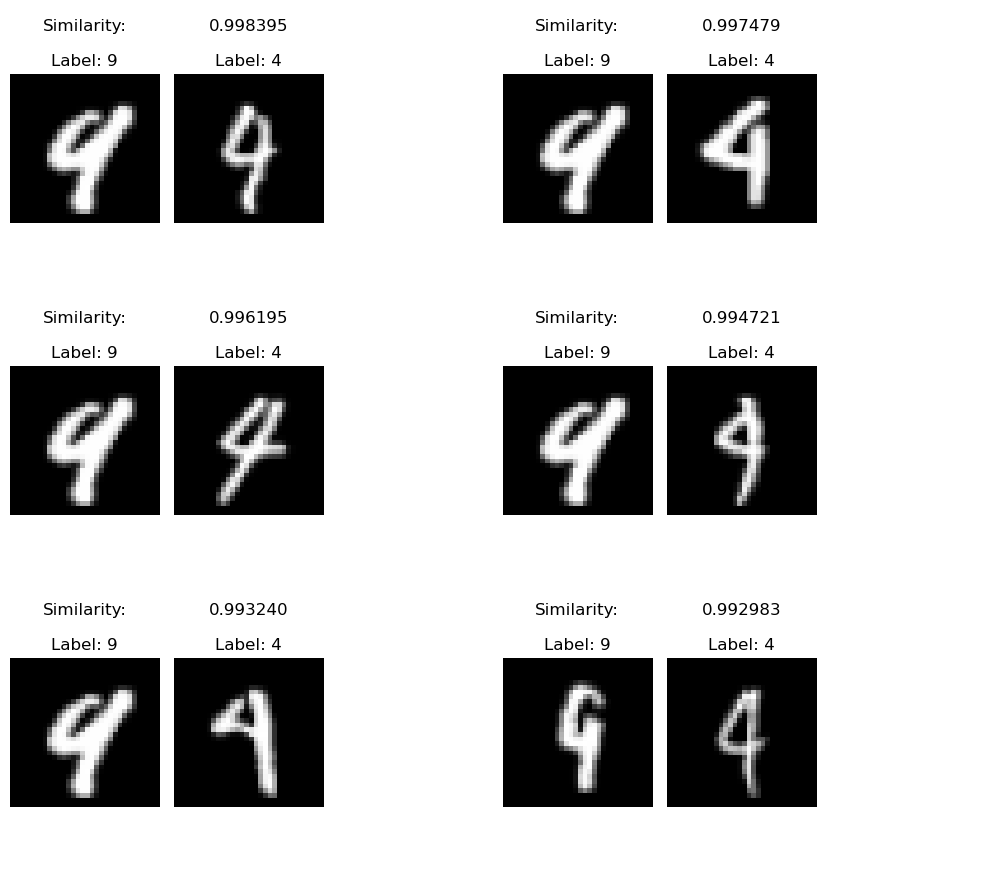

In [15]:
display_similar_items(9, 4, k=6)

### Plotting 9s and 4s that are very different from each other

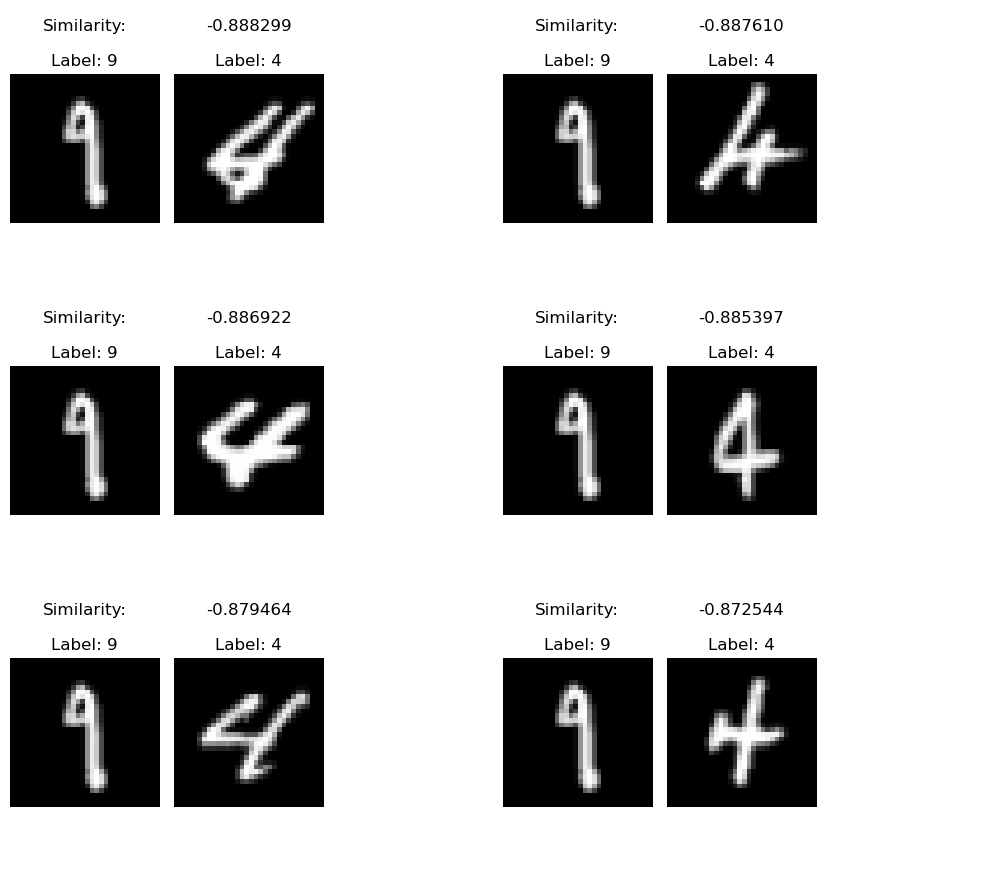

In [16]:
display_dissimilar_items(9, 4, k=6)

### Plotting 9s that are very different from each other

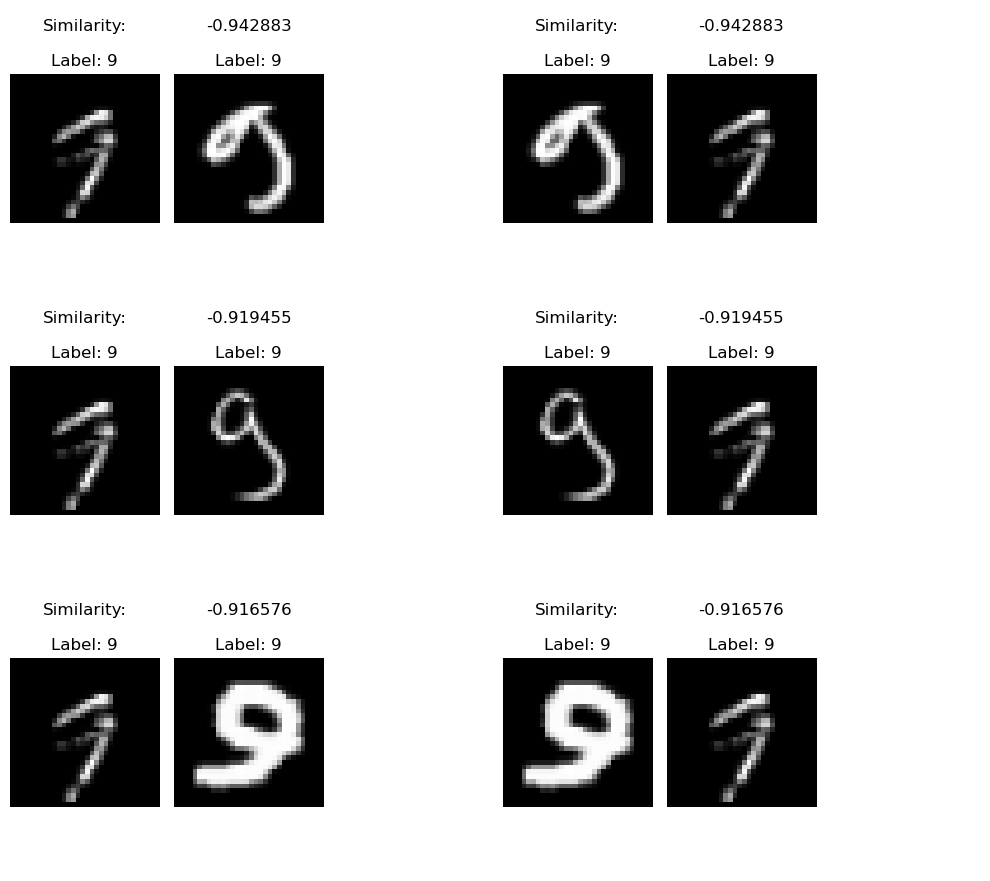

In [17]:
display_dissimilar_items(9, 9, k=6)

## Digging deepest

As the last attempt, let's see the center for each digit. This means the samples that are most similar to the rest of the its cohort. Also, let's find the samples that are furthest away from the rest. In other words, the ones that are the least like the rest.

In [18]:
import torch
import torchvision
import matplotlib.pyplot as plt

def display_mnist(test_tensor, indices_list, label, columns=2):
    # Display pairs of images corresponding to the given pairs of indices
    num_pairs = len(indices_list)
    num_rows = -(-num_pairs // columns)  # Ceiling division to calculate the number of rows
    
    fig, axes = plt.subplots(num_rows, columns, figsize=(5 * columns, 3 * num_rows))

    for i, (idx, sim) in enumerate(indices_list):
        image = test_tensor[idx, :, :, :]

        row = i // columns
        col = i % columns

        if num_rows > 1:
            axes[row, col].imshow(image.squeeze().numpy(), cmap='gray')
            axes[row, col].set_title(f"Average Similarity: {sim:>8f}")
            axes[row, col].axis('off')
        else:
            axes[col].imshow(image.squeeze().numpy(), cmap='gray')
            axes[col].set_title(f"Average Similarity: {sim:>8f}")
            axes[col].axis('off')

    plt.tight_layout()
    plt.show()


def find_indices_of_top_k(tensor_2d, k, largest=True):
    values, indices = tensor_2d.reshape(-1).topk(k, largest=largest)
    
    # Convert indices to row and column indices
    row_indices = indices // tensor_2d.size(1)
    col_indices = indices % tensor_2d.size(1)

    return [(row_indices[i].item(), col_indices[i].item(), values[i].item()) for i in range(k)]


def display_most_items(d, popular=True, k=10):
    # Finding the start and end index for the d1 digit in test_samples
    start = sum([len(test_samples[i]) for i in range(10) if i < d])
    end = sum([len(test_samples[i]) for i in range(10) if i < d+1])

    square = similarity[start:end, start:end]
    s = torch.sum(square, dim=0)

    values, indices = s.topk(k, largest=popular)
    max_indices = [(indices[i].item() + start, values[i].item() / square.shape[0]) for i in range(k)]
    
    display_mnist(test_tensor, max_indices, d, 4)

### The most popular 0s

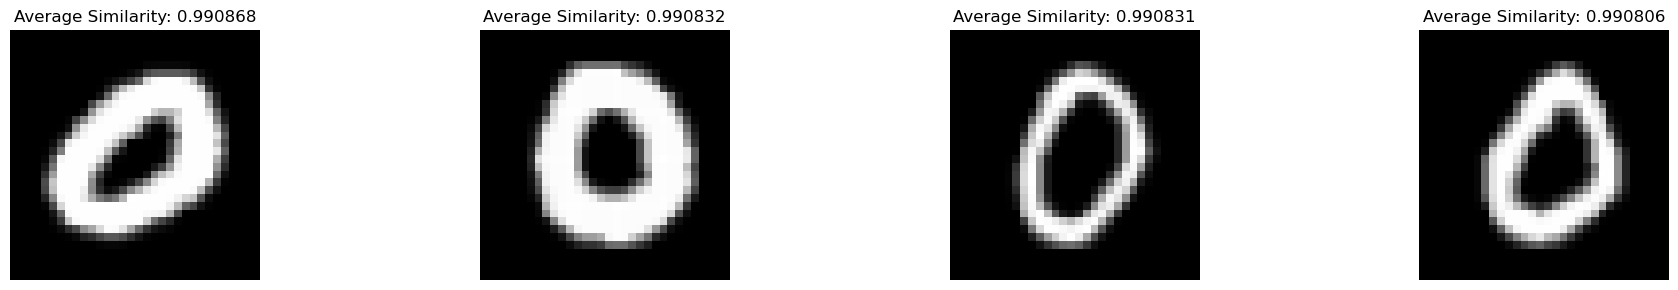

In [19]:
display_most_items(0, popular=True, k=4)

### The least popular 0s

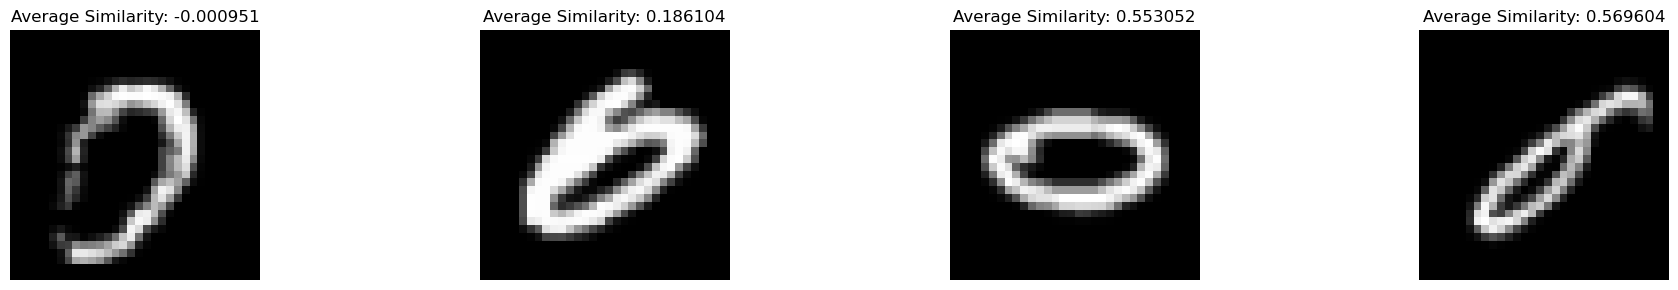

In [20]:
display_most_items(0, popular=False, k=4)

### The most popular 1s

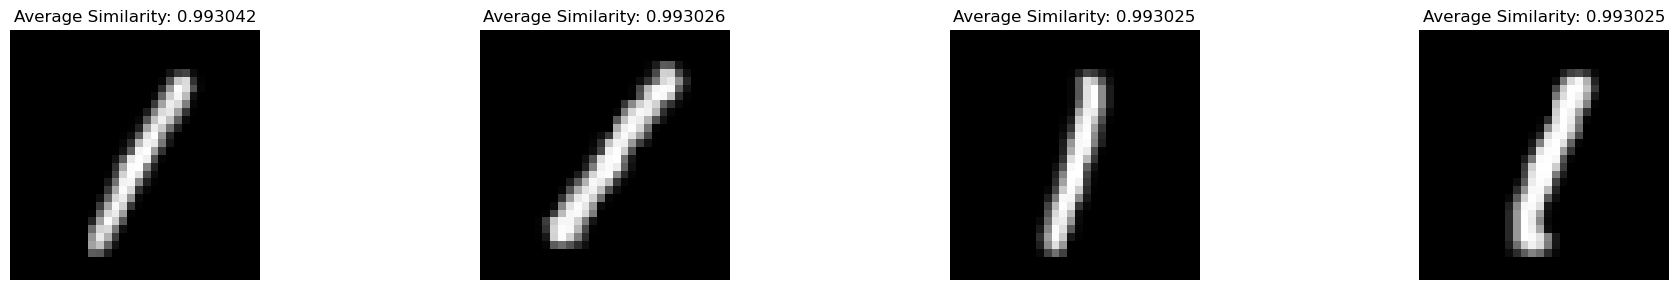

In [21]:
display_most_items(1, popular=True, k=4)

### The least popular 1s

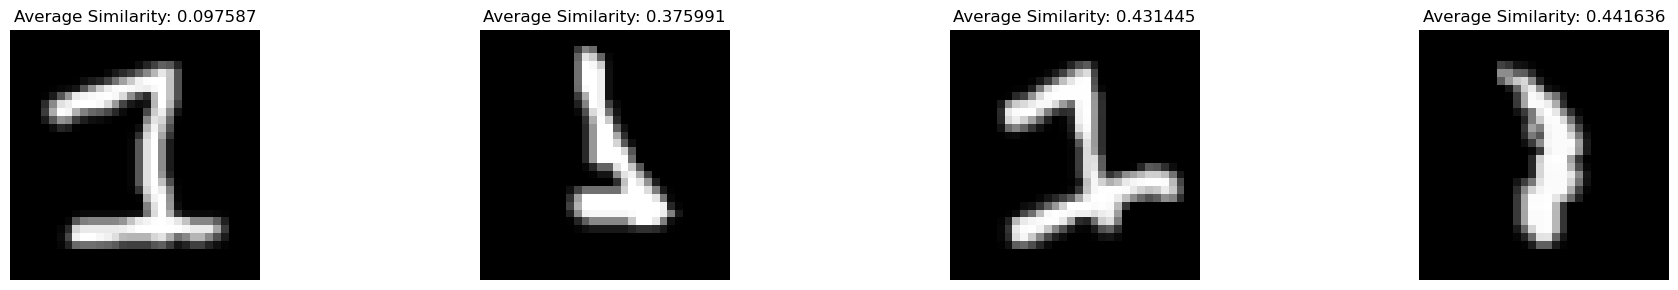

In [22]:
display_most_items(1, popular=False, k=4)

### The most popular 2s

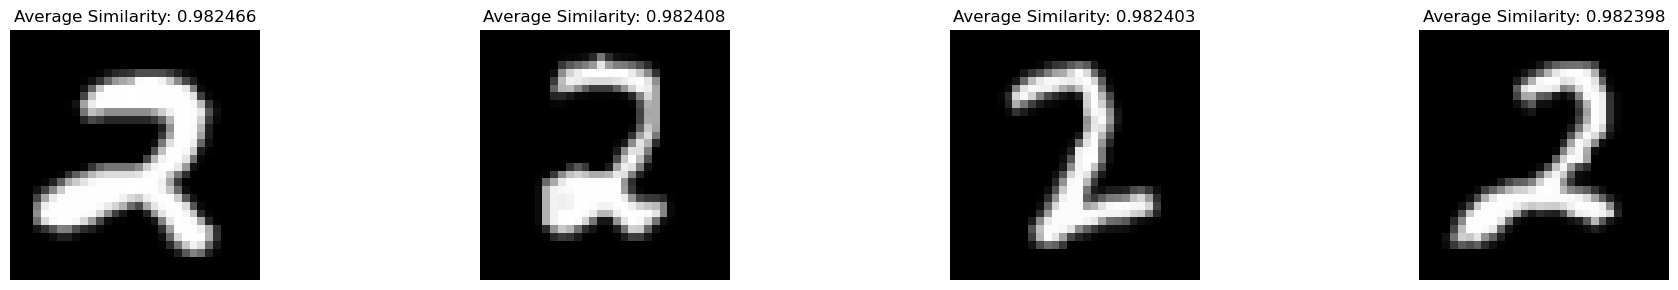

In [23]:
display_most_items(2, popular=True, k=4)

### The least popular 2s

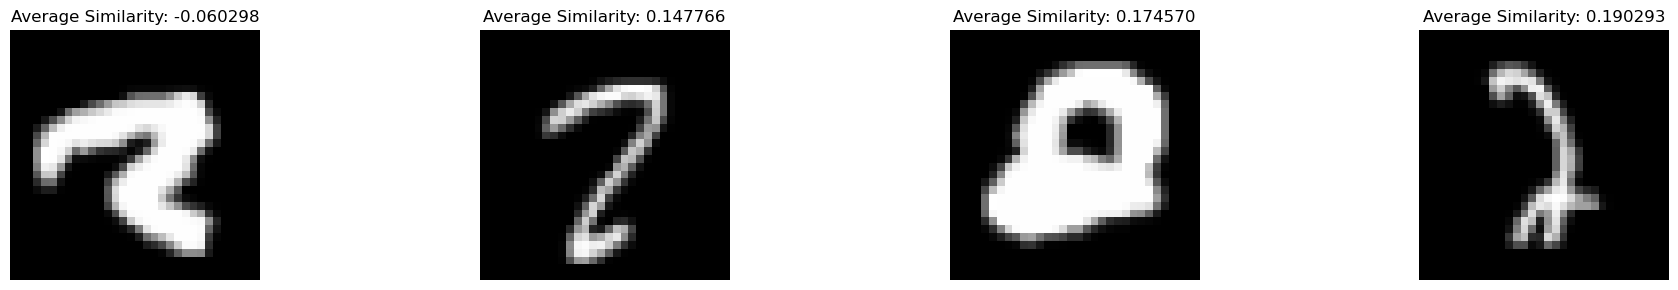

In [24]:
display_most_items(2, popular=False, k=4)

### The most popular 3s

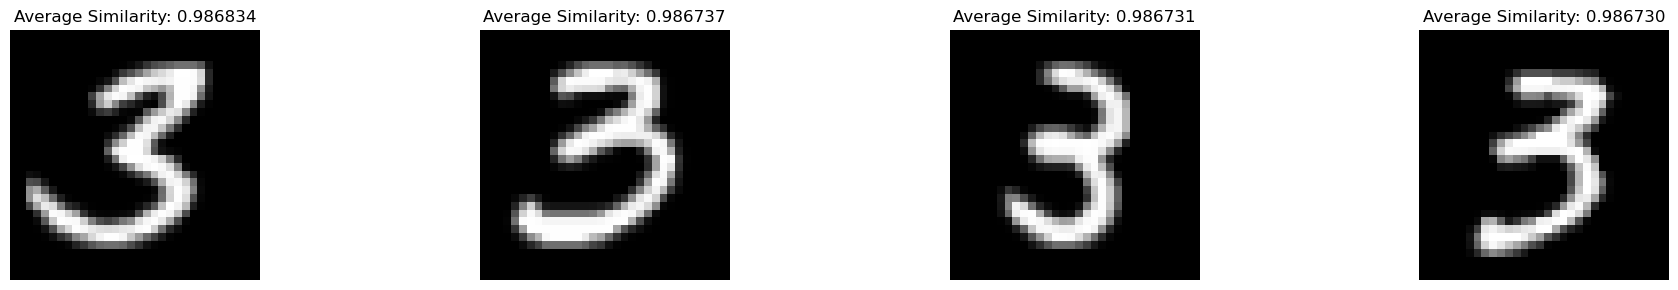

In [25]:
display_most_items(3, popular=True, k=4)

### The least popular 3s

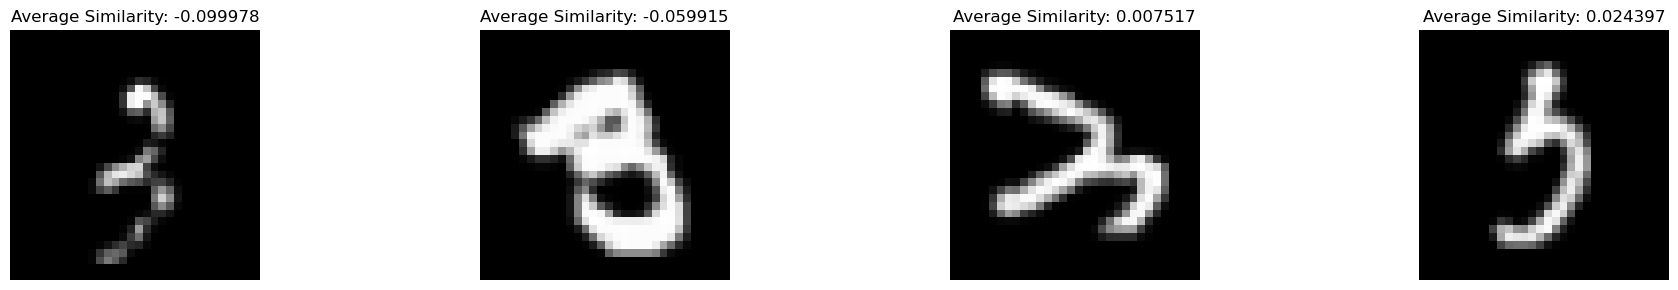

In [26]:
display_most_items(3, popular=False, k=4)

### The most popular 4s

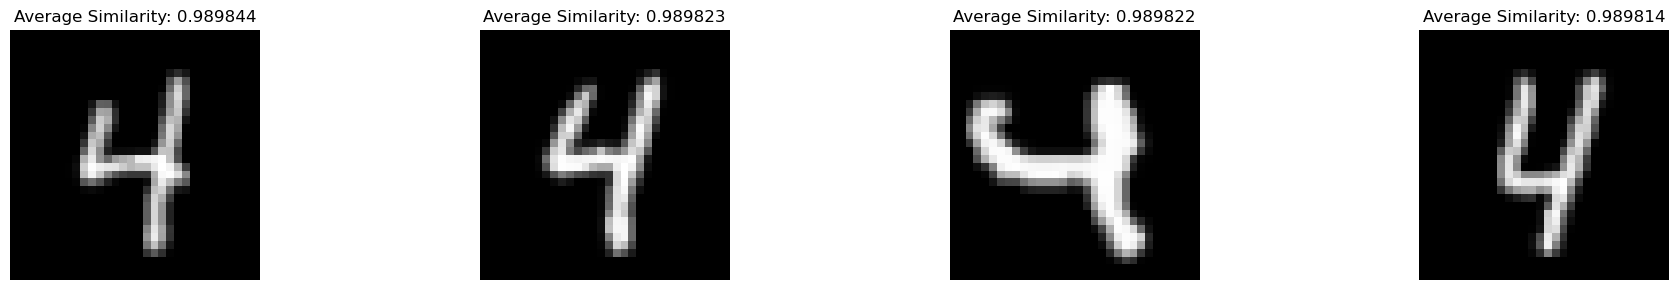

In [27]:
display_most_items(4, popular=True, k=4)

### The least popular 4s

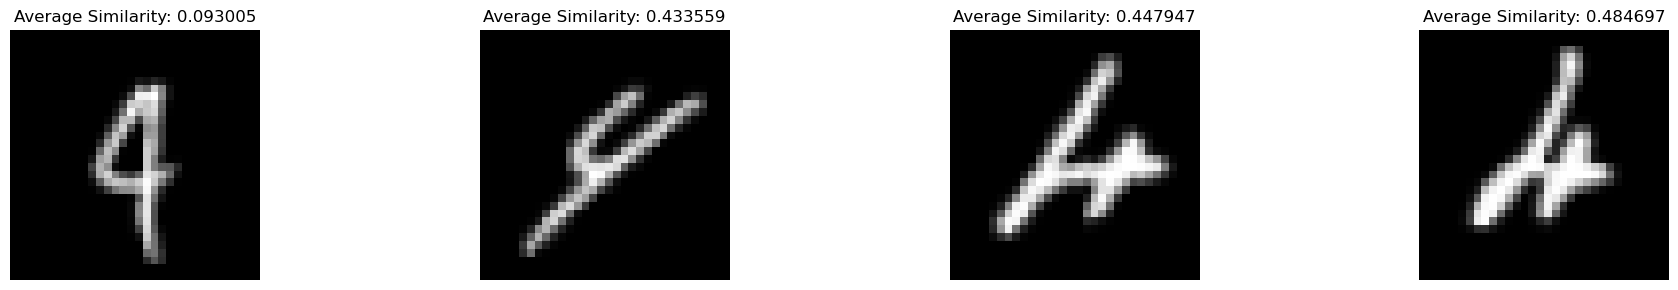

In [28]:
display_most_items(4, popular=False, k=4)

### The most popular 5s

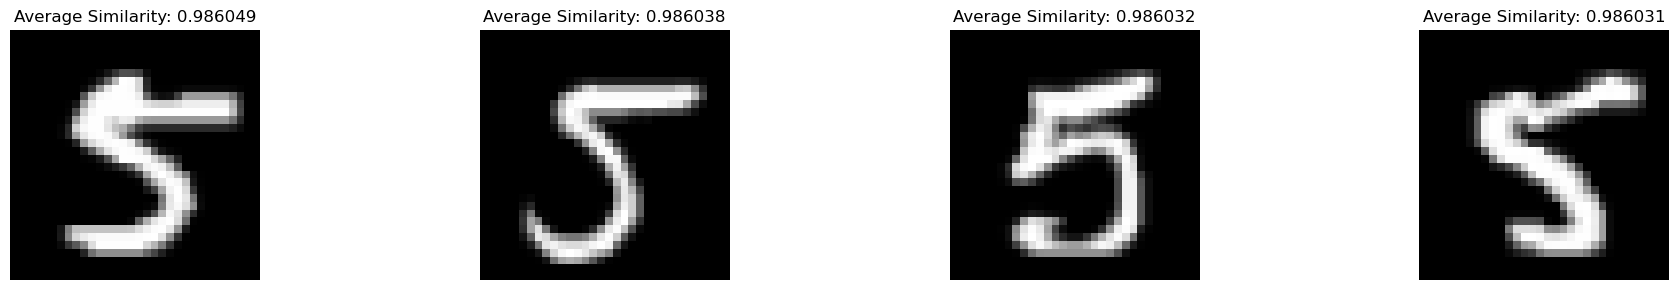

In [29]:
display_most_items(5, popular=True, k=4)

### The least popular 5s

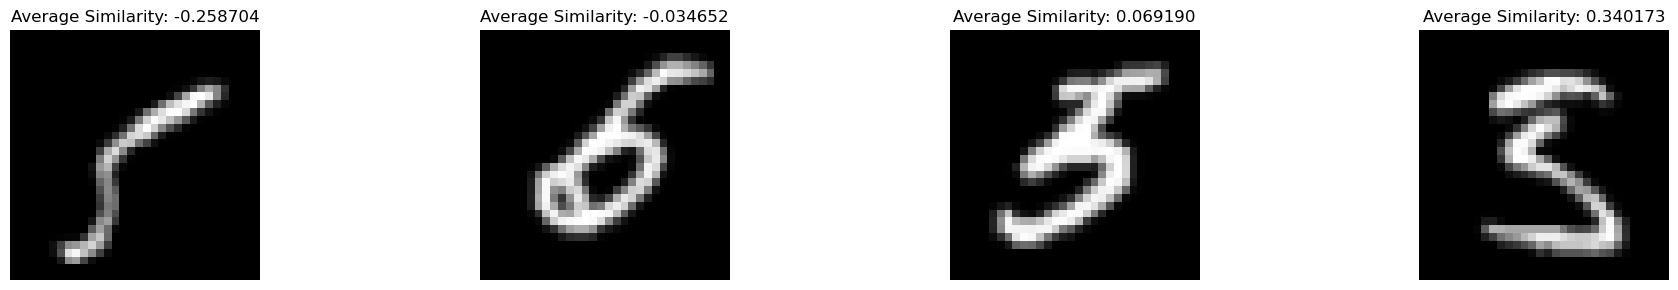

In [30]:
display_most_items(5, popular=False, k=4)

### The most popular 6s

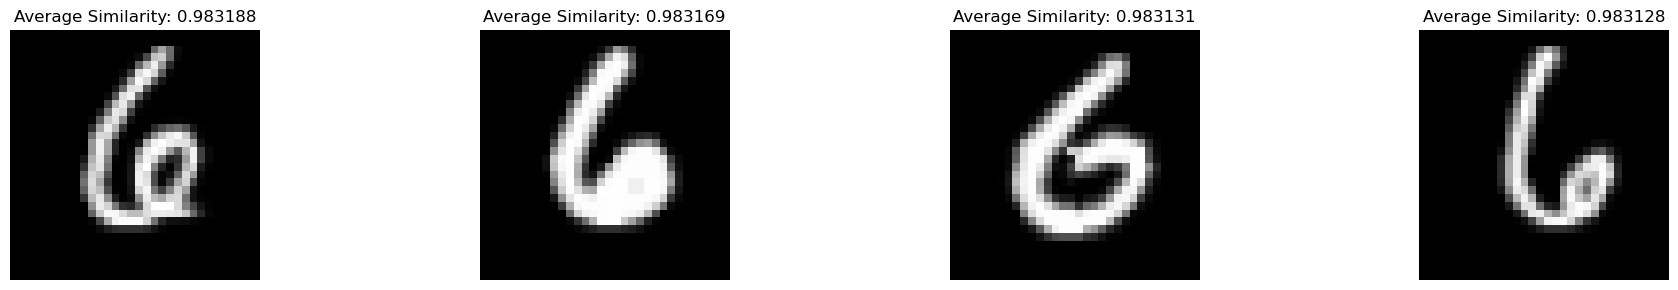

In [31]:
display_most_items(6, popular=True, k=4)

### The least popular 6s

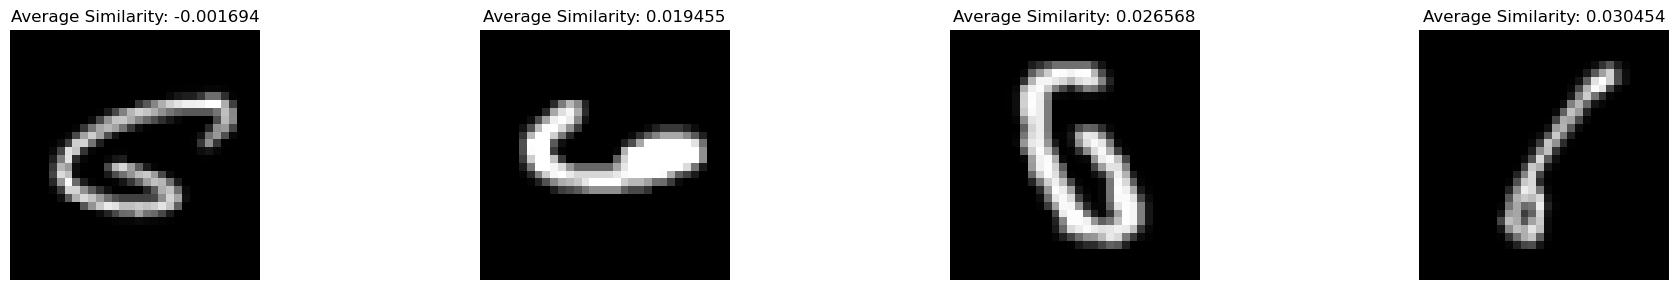

In [32]:
display_most_items(6, popular=False, k=4)

### The most popular 7s

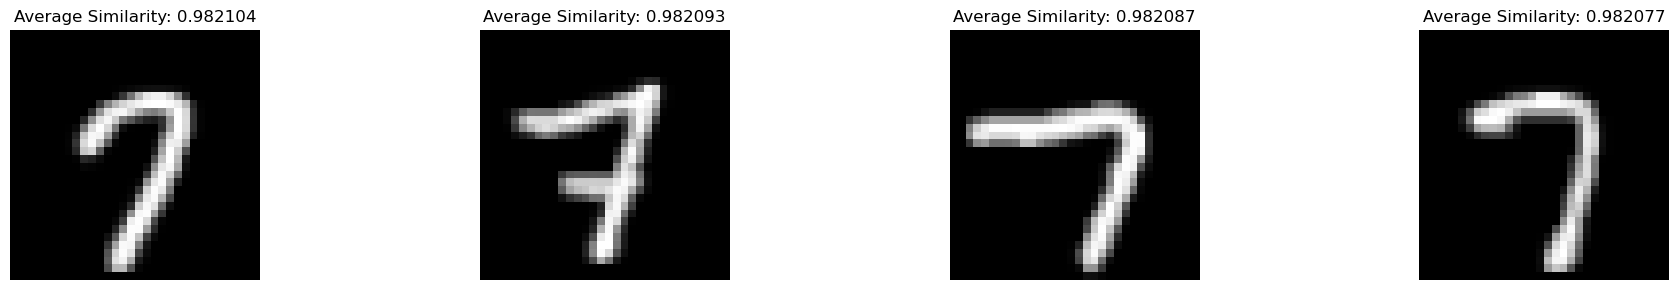

In [33]:
display_most_items(7, popular=True, k=4)

### The least popular 7s

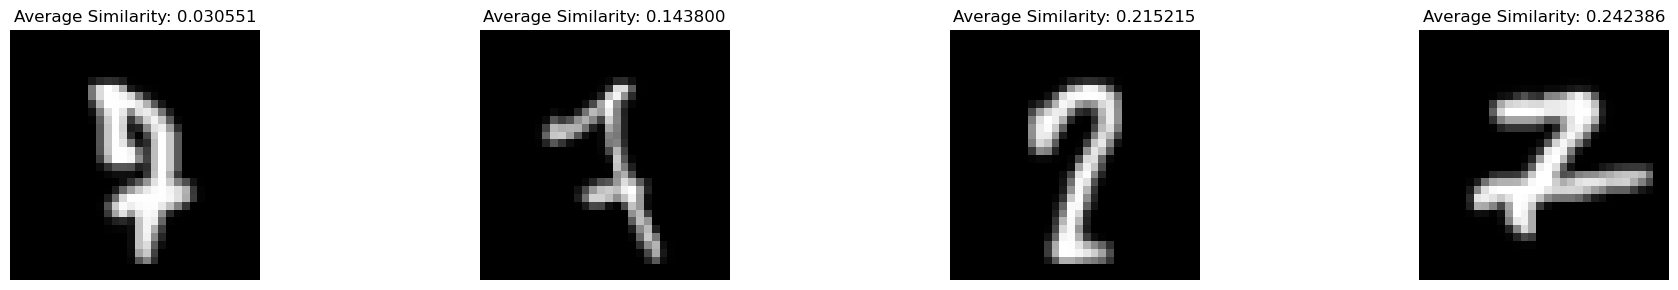

In [34]:
display_most_items(7, popular=False, k=4)

### The most popular 8s

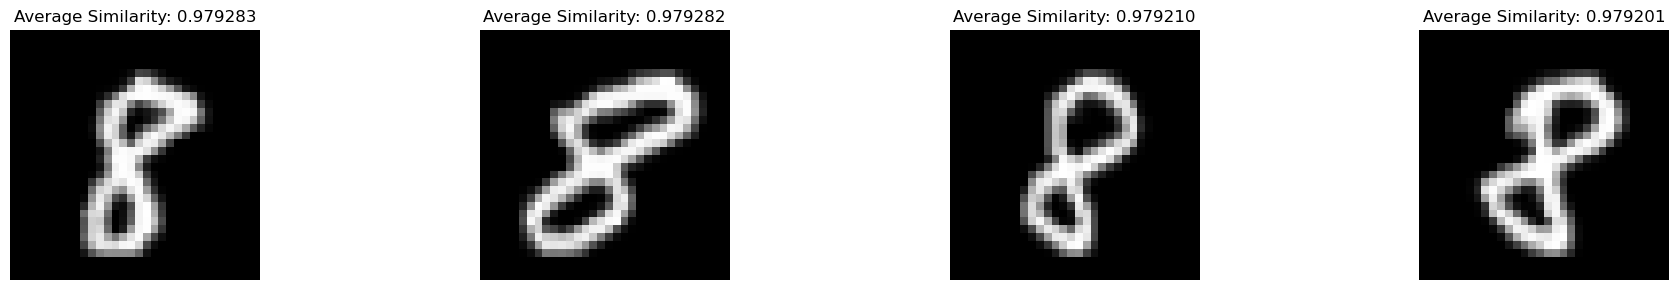

In [35]:
display_most_items(8, popular=True, k=4)

### The least popular 8s

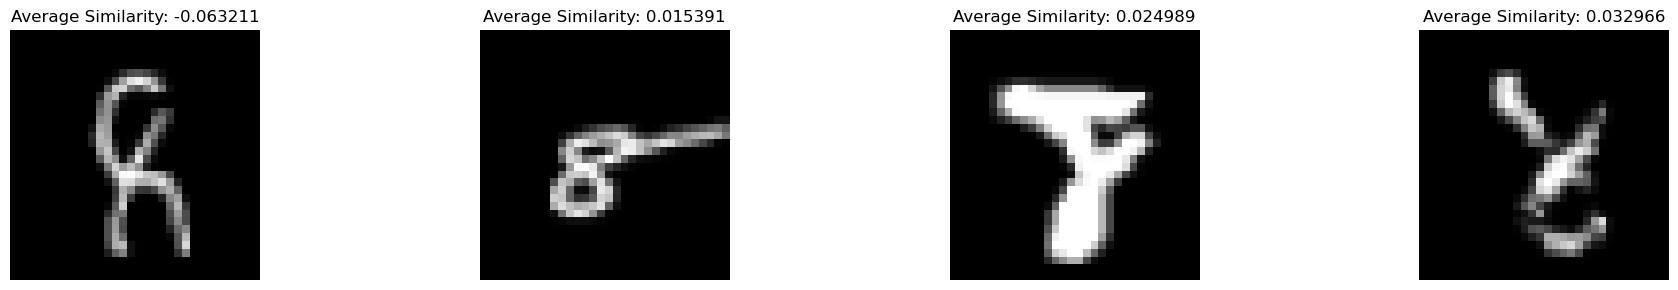

In [36]:
display_most_items(8, popular=False, k=4)

### The most popular 9s

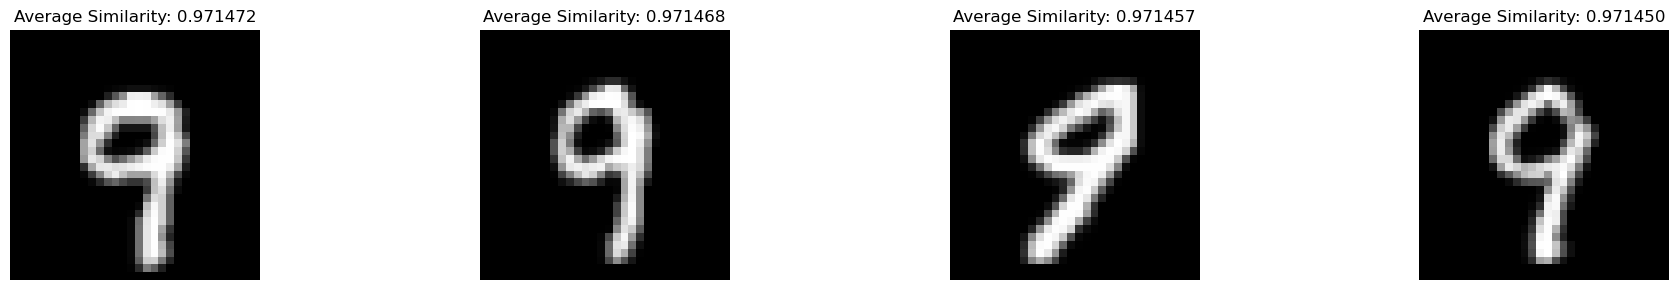

In [37]:
display_most_items(9, popular=True, k=4)

### The least popular 9s

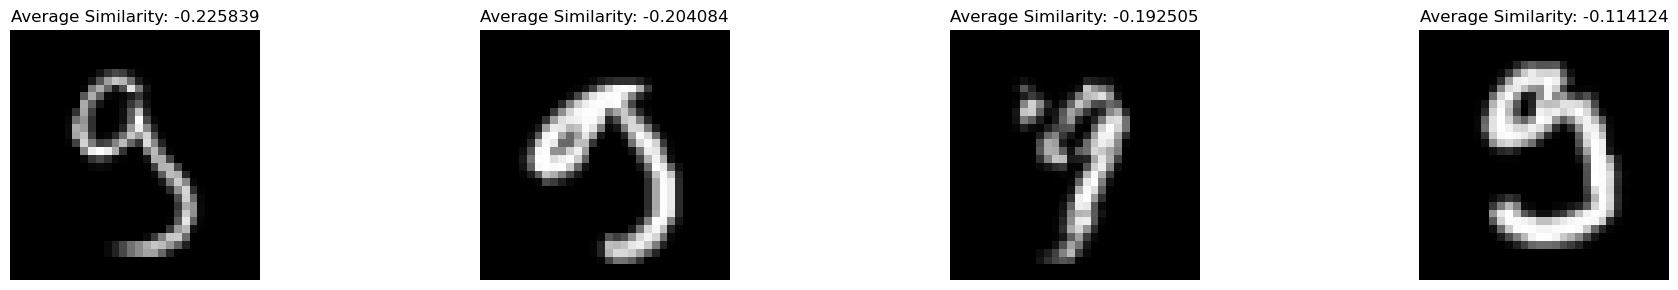

In [38]:
display_most_items(9, popular=False, k=4)